#  Kubernetes Logs Threat Analysis
## Detection of Suspicious Patterns and Attacks in Kubernetes

This notebook analyzes Google Kubernetes Engine (GKE) audit logs to identify:
- Suspicious activities
- Attack patterns
- Behavioral anomalies
- Privilege escalations
- Unauthorized access


In [34]:
# Import necessary libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
import re
from collections import Counter
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ Libraries loaded successfully")


✅ Libraries loaded successfully


In [44]:
# Load Kubernetes logs data
df = pd.read_csv('test.csv')

print(f"📊 Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"📅 Time range: {df['timestamp'].min()} - {df['timestamp'].max()}")

# Show basic dataset information
print("\n🔍 Dataset information:")
print(f"Main columns: {', '.join(df.columns[:10])}...")
print(f"Unique data types: {df.dtypes.value_counts().to_dict()}")

# Show first rows
print("\n📋 First rows of dataset:")
df.head(2)


📊 Dataset loaded: 853 rows, 68 columns
📅 Time range: 2025-06-20T08:13:24.308266Z - 2025-06-20T08:14:59.943381Z

🔍 Dataset information:
Main columns: timestamp, user, hostname, process name, event type, udm.metadata.id, udm.metadata.product_log_id, udm.metadata.event_timestamp, udm.metadata.collected_timestamp, udm.metadata.ingested_timestamp...
Unique data types: {dtype('O'): 55, dtype('float64'): 12, dtype('bool'): 1}

📋 First rows of dataset:


,timestamp,user,hostname,process name,event type,udm.metadata.id,udm.metadata.product_log_id,udm.metadata.event_timestamp,udm.metadata.collected_timestamp,udm.metadata.ingested_timestamp,...,udm.principal.ip_geo_artifact.location.state,udm.principal.ip_geo_artifact.location.country_or_region,udm.principal.ip_geo_artifact.location.region_latitude,udm.principal.ip_geo_artifact.location.region_longitude,udm.principal.ip_geo_artifact.location.region_coordinates.latitude,udm.principal.ip_geo_artifact.location.region_coordinates.longitude,udm.principal.ip_geo_artifact.network.dns_domain,udm.principal.ip_geo_artifact.network.carrier_name,udm.principal.ip_geo_artifact.network.organization_name,udm.principal.namespace
0,2025-06-20T08:14:59.943381Z,devops-tools-flux-oke-sa,NaN,NaN,RESOURCE_WRITTEN,AAAAAJAzFYOkKjX6Exws6nnPLVUAAAAADgAAAAsAAAA=,56c8cb34-f4f0-48a5-ac69-249d3659d61c,2025-06-20T08:14:59.943381Z,2025-06-20T08:15:00.035924Z,2025-06-20T08:15:03.650086Z,...,Brussels,Belgium,50.826046,4.380205,50.826045,4.380205,Oracleusercont.com,Oracle,Oracle,default
1,2025-06-20T08:14:59.068010Z,devops-tools-flux-oke-sa,NaN,NaN,RESOURCE_WRITTEN,AAAAAKbZzkVPJHsz6XPhHjikoH0AAAAADgAAAF4AAAA=,e3020459-adb8-4fe5-a29f-d225630f8016,2025-06-20T08:14:59.068010Z,2025-06-20T08:15:00.071836Z,2025-06-20T08:15:04.654842Z,...,Brussels,Belgium,50.826046,4.380205,50.826045,4.380205,Oracleusercont.com,Oracle,Oracle,default


In [46]:
# Data preprocessing
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.day_name()
df['date'] = df['timestamp'].dt.date

# Extract key information from complex columns
df['source_ip'] = df['udm.principal.ip']
df['user_email'] = df['udm.principal.user.email_addresses']
df['location'] = df['udm.principal.location.country_or_region']
df['event_type'] = df['event type']
df['resource_type'] = df['udm.target.resource.resource_type']

print("✅ Preprocessing completed")
print(f"🌍 Unique countries detected: {df['location'].nunique()}")
print(f"👤 Unique users: {df['user'].nunique()}")
print(f"🔍 Unique IPs: {df['source_ip'].nunique()}")

# Show basic distribution
print(f"\n📊 Event distribution by type:")
print(df['event_type'].value_counts().head())


✅ Preprocessing completed
🌍 Unique countries detected: 1
👤 Unique users: 8
🔍 Unique IPs: 9

📊 Event distribution by type:
event_type
RESOURCE_WRITTEN     819
RESOURCE_CREATION     34
Name: count, dtype: int64


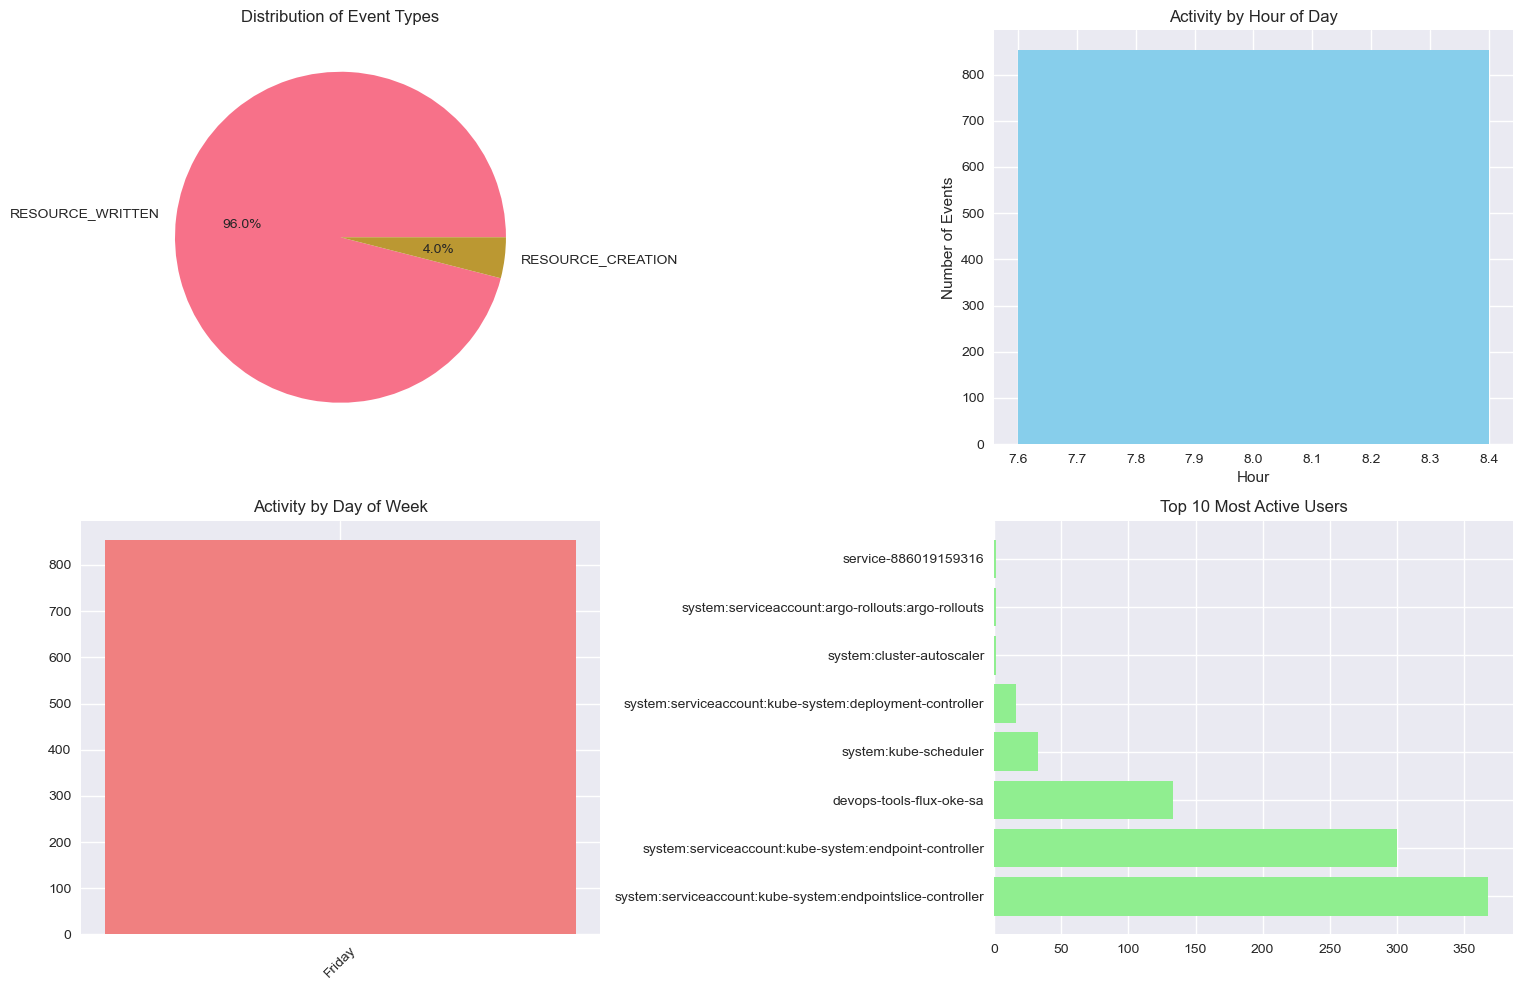

In [48]:
# Summary of events by type
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Distribution of event types
event_counts = df['event_type'].value_counts()
axes[0,0].pie(event_counts.values, labels=event_counts.index, autopct='%1.1f%%')
axes[0,0].set_title('Distribution of Event Types')

# Activity by hour of day
hourly_activity = df['hour'].value_counts().sort_index()
axes[0,1].bar(hourly_activity.index, hourly_activity.values, color='skyblue')
axes[0,1].set_title('Activity by Hour of Day')
axes[0,1].set_xlabel('Hour')
axes[0,1].set_ylabel('Number of Events')

# Activity by day of week
daily_activity = df['day_of_week'].value_counts()
axes[1,0].bar(daily_activity.index, daily_activity.values, color='lightcoral')
axes[1,0].set_title('Activity by Day of Week')
axes[1,0].tick_params(axis='x', rotation=45)

# Top 10 most active users
top_users = df['user'].value_counts().head(10)
axes[1,1].barh(top_users.index, top_users.values, color='lightgreen')
axes[1,1].set_title('Top 10 Most Active Users')

plt.tight_layout()
plt.show()


In [ ]:
## Threat Detection and Suspicious Patterns


In [50]:
# Volume Anomaly and Off-Hours Activity Detection
# Metrics: Identifies users with abnormally high activity using statistical thresholds (mean + 3*std).
# Detects suspicious activity outside business hours (8:00-18:00) which may indicate unauthorized access.

# 1. VOLUME ANOMALY DETECTION
def detect_volume_anomalies(df, threshold_multiplier=3):
    """
    Detects anomalous activity based on event volume per user
    """
    user_activity = df['user'].value_counts()
    mean_activity = user_activity.mean()
    std_activity = user_activity.std()
    threshold = mean_activity + (threshold_multiplier * std_activity)
    
    anomalous_users = user_activity[user_activity > threshold]
    
    print(f"ALERT: Users with anomalous activity (>{threshold:.0f} events):")
    for user, count in anomalous_users.items():
        print(f"    {user}: {count} events")
    
    return anomalous_users

# 2. OFF-HOURS ACTIVITY DETECTION
def detect_off_hours_activity(df, normal_hours=(8, 18)):
    """
    Detects activity outside normal working hours
    """
    off_hours = df[(df['hour'] < normal_hours[0]) | (df['hour'] > normal_hours[1])]
    
    print(f"OFF-HOURS ACTIVITY ({normal_hours[0]}:00-{normal_hours[1]}:00):")
    print(f"    {len(off_hours)} events ({len(off_hours)/len(df)*100:.1f}% of total)")
    
    if len(off_hours) > 0:
        suspicious_off_hours = off_hours['user'].value_counts().head(10)
        print("   Most active users off-hours:")
        for user, count in suspicious_off_hours.items():
            print(f"    User  {user}: {count} events")
    
    return off_hours

# Execute detections
print("STARTING THREAT ANALYSIS...\n")

anomalous_users = detect_volume_anomalies(df)
print("\n" + "="*60 + "\n")

off_hours_activity = detect_off_hours_activity(df)
print("\n" + "="*60 + "\n")


🔍 STARTING THREAT ANALYSIS...

ALERT: Users with anomalous activity (>551 events):


OFF-HOURS ACTIVITY (8:00-18:00):
    0 events (0.0% of total)




In [21]:
# Multi-IP and Geographic Pattern Analysis
# Metrics: Identifies users connecting from multiple IP addresses, which may indicate compromised accounts.
# Analyzes geographic distribution and detects users accessing from multiple countries simultaneously.

# 3. MULTIPLE IPs PER USER DETECTION
def detect_multiple_ips(df):
    """
    Detects users connecting from multiple IPs
    """
    user_ips = df.groupby('user')['source_ip'].nunique().sort_values(ascending=False)
    suspicious_users = user_ips[user_ips > 1]
    
    print(f" USERS WITH MULTIPLE IPs:")
    for user, ip_count in suspicious_users.head(10).items():
        user_data = df[df['user'] == user]
        ips = user_data['source_ip'].unique()
        print(f"   {user}: {ip_count} different IPs")
        for ip in ips:
            ip_events = len(user_data[user_data['source_ip'] == ip])
            print(f"      {ip}: {ip_events} events")
    
    return suspicious_users

# 4. SUSPICIOUS GEOGRAPHIC PATTERNS ANALYSIS
def analyze_geographic_patterns(df):
    """
    Analyzes suspicious geographic patterns
    """
    print(" GEOGRAPHIC ANALYSIS:")
    
    # Distribution by country
    country_dist = df['location'].value_counts()
    print(f"    Activity by country:")
    for country, count in country_dist.head(10).items():
        print(f"      {country}: {count} events ({count/len(df)*100:.1f}%)")
    
    # Users connecting from multiple countries
    user_countries = df.groupby('user')['location'].nunique().sort_values(ascending=False)
    multi_country_users = user_countries[user_countries > 1]
    
    if len(multi_country_users) > 0:
        print(f"\n    Users connecting from multiple countries:")
        for user, country_count in multi_country_users.head(5).items():
            user_countries_detail = df[df['user'] == user]['location'].value_counts()
            print(f"      {user}: {country_count} countries")
            for country, events in user_countries_detail.items():
                print(f"       {country}: {events} events")
    
    return country_dist, multi_country_users

# Execute additional analysis
multiple_ip_users = detect_multiple_ips(df)
print("\n" + "="*60 + "\n")

country_dist, multi_country_users = analyze_geographic_patterns(df)
print("\n" + "="*60 + "\n")


 USERS WITH MULTIPLE IPs:
   system:serviceaccount:kube-system:endpointslice-controller: 6 different IPs
      172.16.0.7: 303 events
      172.16.0.10: 43 events
      172.16.0.5: 7 events
      172.16.0.9: 7 events
      172.16.0.6: 6 events
      172.16.0.4: 2 events
   system:serviceaccount:kube-system:endpoint-controller: 4 different IPs
      172.16.0.7: 268 events
      172.16.0.10: 26 events
      172.16.0.5: 4 events
      172.16.0.4: 2 events
   system:kube-scheduler: 3 different IPs
      172.16.0.10: 25 events
      172.16.0.4: 1 events
      172.16.0.7: 7 events
   system:serviceaccount:kube-system:deployment-controller: 2 different IPs
      172.16.0.10: 13 events
      172.16.0.7: 3 events


 GEOGRAPHIC ANALYSIS:
    Activity by country:
      Belgium: 133 events (15.6%)




In [52]:
# Privilege Escalation and Temporal Pattern Detection
# Metrics: Identifies administrative role usage and privilege escalation attempts through permission analysis.
# Detects automated activity patterns by analyzing rapid events and repetitive behaviors indicating bot activity.

# 5. PRIVILEGE ESCALATION DETECTION
def detect_privilege_escalation(df):
    """
    Detects privilege escalation attempts
    """
    print("PRIVILEGE ESCALATION ANALYSIS:")
    
    # Look for administrative roles
    admin_roles = df[df['udm.principal.user.attribute.roles.name'].str.contains('admin|root|cluster-admin', case=False, na=False)]
    
    if len(admin_roles) > 0:
        print(f"    Activity with administrative roles: {len(admin_roles)} events")
        admin_users = admin_roles['user'].value_counts()
        print("   Users with admin roles:")
        for user, count in admin_users.head(10).items():
            print(f"     {user}: {count} events")
    
    # Analyze specific permissions
    permission_patterns = [
        'serviceaccounts.patch',
        'serviceaccounts.create',
        'secrets.create',
        'pods.create',
        'roles.create'
    ]
    
    for pattern in permission_patterns:
        matching_events = df[df['udm.metadata.product_event_type'].str.contains(pattern, case=False, na=False)]
        if len(matching_events) > 0:
            print(f"   {pattern} operations: {len(matching_events)} events")
            top_users_pattern = matching_events['user'].value_counts().head(3)
            for user, count in top_users_pattern.items():
                print(f"     {user}: {count} operations")
    
    return admin_roles

# 6. TEMPORAL PATTERN ANALYSIS
def analyze_temporal_patterns(df):
    """
    Analyzes temporal patterns that may indicate automated activity or attacks
    """
    print("TEMPORAL PATTERN ANALYSIS:")
    
    # Detect activity bursts (many events in short time)
    df_sorted = df.sort_values('timestamp')
    df_sorted['time_diff'] = df_sorted.groupby('user')['timestamp'].diff().dt.total_seconds()
    
    # Events with less than 1 second difference (possible automation)
    rapid_events = df_sorted[df_sorted['time_diff'] < 1.0]
    
    if len(rapid_events) > 0:
        print(f"   Rapid events (< 1 second): {len(rapid_events)}")
        rapid_users = rapid_events['user'].value_counts().head(5)
        print("   Possible automated activity:")
        for user, count in rapid_users.items():
            print(f"     {user}: {count} rapid events")
    
    # Detect highly repetitive activity
    user_event_patterns = df.groupby(['user', 'event_type']).size().reset_index(name='count')
    repetitive_patterns = user_event_patterns[user_event_patterns['count'] > 50]
    
    if len(repetitive_patterns) > 0:
        print(f"   Repetitive patterns detected:")
        for _, row in repetitive_patterns.head(10).iterrows():
            print(f"     {row['user']}: {row['event_type']} x{row['count']}")
    
    return rapid_events, repetitive_patterns

# Execute privilege and temporal pattern analysis
admin_roles = detect_privilege_escalation(df)
print("\n" + "="*60 + "\n")

rapid_events, repetitive_patterns = analyze_temporal_patterns(df)


🔐 PRIVILEGE ESCALATION ANALYSIS:
    Activity with administrative roles: 133 events
   Users with admin roles:
     🔑 devops-tools-flux-oke-sa: 133 events
   serviceaccounts.patch operations: 114 events
     devops-tools-flux-oke-sa: 114 operations


⏰ TEMPORAL PATTERN ANALYSIS:
   Rapid events (< 1 second): 789
   Possible automated activity:
     system:serviceaccount:kube-system:endpointslice-controller: 362 rapid events
     system:serviceaccount:kube-system:endpoint-controller: 293 rapid events
     devops-tools-flux-oke-sa: 102 rapid events
     system:kube-scheduler: 24 rapid events
     system:serviceaccount:kube-system:deployment-controller: 8 rapid events
   Repetitive patterns detected:
     devops-tools-flux-oke-sa: RESOURCE_WRITTEN x133
     system:serviceaccount:kube-system:endpoint-controller: RESOURCE_WRITTEN x300
     system:serviceaccount:kube-system:endpointslice-controller: RESOURCE_WRITTEN x368


In [26]:
# Multi-Factor Risk Scoring System
# Metrics: Calculates composite risk scores using 6 factors: activity volume, multiple IPs, geographic spread, off-hours activity, admin roles, and repetitive patterns.
# Classifies users into HIGH (>50), MEDIUM (20-50), and LOW (<20) risk categories for prioritized security response.

def calculate_risk_score(df):
    """
    Calculates a risk score for each user based on multiple factors
    """
    user_risk_scores = {}
    
    for user in df['user'].unique():
        user_data = df[df['user'] == user]
        risk_score = 0
        risk_factors = []
        
        # Factor 1: Activity volume (normalized)
        activity_count = len(user_data)
        avg_activity = df['user'].value_counts().mean()
        if activity_count > avg_activity * 2:
            risk_score += 20
            risk_factors.append(f"High activity ({activity_count} events)")
        
        # Factor 2: Multiple IPs
        unique_ips = user_data['source_ip'].nunique()
        if unique_ips > 1:
            risk_score += 15 * unique_ips
            risk_factors.append(f"Multiple IPs ({unique_ips})")
        
        # Factor 3: Multiple countries
        unique_countries = user_data['location'].nunique()
        if unique_countries > 1:
            risk_score += 25 * unique_countries
            risk_factors.append(f"Multiple countries ({unique_countries})")
        
        # Factor 4: Off-hours activity
        off_hours_events = user_data[(user_data['hour'] < 8) | (user_data['hour'] > 18)]
        if len(off_hours_events) > 0:
            risk_score += 10 + (len(off_hours_events) * 2)
            risk_factors.append(f"Off-hours activity ({len(off_hours_events)} events)")
        
        # Factor 5: Administrative roles
        if user_data['udm.principal.user.attribute.roles.name'].str.contains('admin|container.admin', case=False, na=False).any():
            risk_score += 30
            risk_factors.append("Administrative roles")
        
        # Factor 6: Excessive repetitive activity
        event_type_counts = user_data['event_type'].value_counts()
        if event_type_counts.max() > 50:
            risk_score += 15
            risk_factors.append(f"Repetitive activity ({event_type_counts.max()} events of same type)")
        
        user_risk_scores[user] = {
            'score': risk_score,
            'factors': risk_factors,
            'level': 'HIGH' if risk_score > 50 else 'MEDIUM' if risk_score > 20 else 'LOW'
        }
    
    return user_risk_scores

# Calculate risk scores
risk_scores = calculate_risk_score(df)

# Show high-risk users
high_risk_users = {k: v for k, v in risk_scores.items() if v['level'] == 'HIGH'}
medium_risk_users = {k: v for k, v in risk_scores.items() if v['level'] == 'MEDIUM'}

print(" HIGH-RISK USERS:")
for user, data in sorted(high_risk_users.items(), key=lambda x: x[1]['score'], reverse=True):
    print(f"\n {user} - Score: {data['score']} ({data['level']})")
    print("   Risk factors:")
    for factor in data['factors']:
        print(f"     - {factor}")

if medium_risk_users:
    print("\n MEDIUM-RISK USERS:")
    for user, data in sorted(medium_risk_users.items(), key=lambda x: x[1]['score'], reverse=True)[:5]:
        print(f"    {user}: {data['score']} points")


 HIGH-RISK USERS:

 system:serviceaccount:kube-system:endpointslice-controller - Score: 125 (HIGH)
   Risk factors:
     • High activity (368 events)
     • Multiple IPs (6)
     • Repetitive activity (368 events of same type)

 system:serviceaccount:kube-system:endpoint-controller - Score: 95 (HIGH)
   Risk factors:
     • High activity (300 events)
     • Multiple IPs (4)
     • Repetitive activity (300 events of same type)

 MEDIUM-RISK USERS:
    devops-tools-flux-oke-sa: 45 points
    system:kube-scheduler: 45 points
    system:serviceaccount:kube-system:deployment-controller: 30 points


## CELL 10: Threat Visualizations
**Metrics**: Provides visual analytics for threat assessment including risk distributions and activity patterns.
**Purpose**: Creates comprehensive dashboards for security team to quickly identify and prioritize threats.


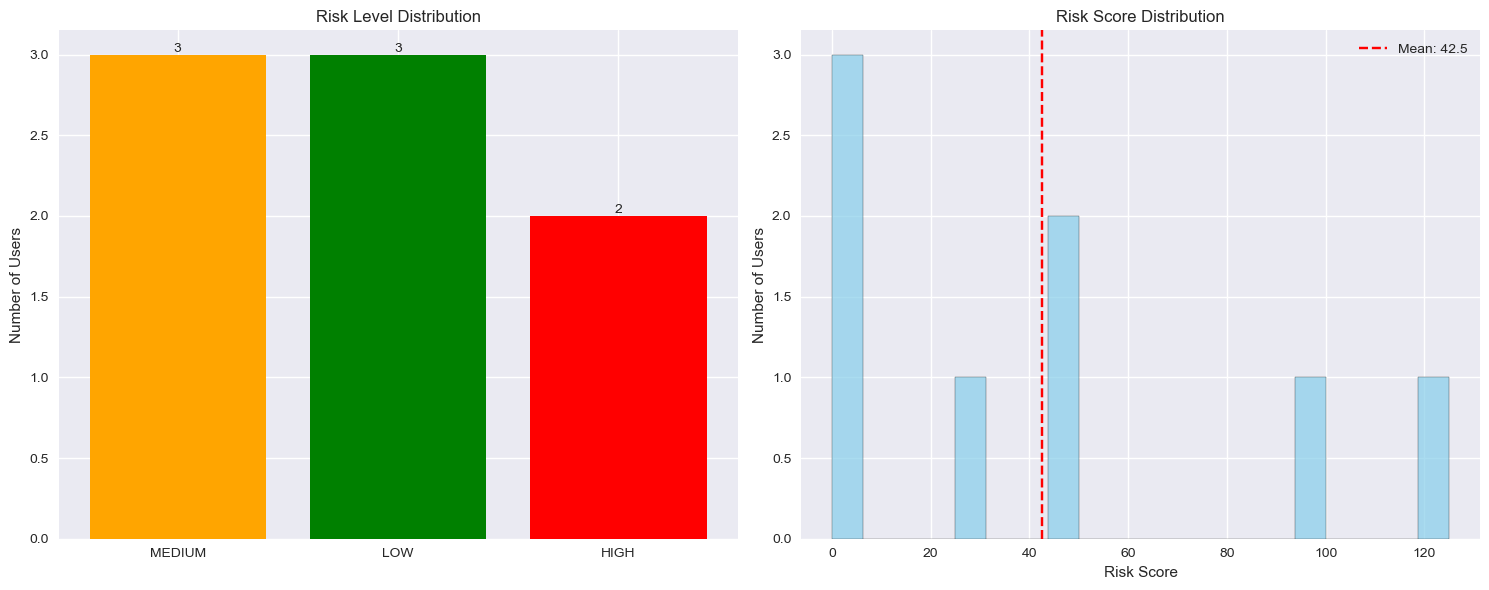


📊 STATISTICAL SUMMARY:
   👥 Total users analyzed: 8
   🚨 High-risk users: 2 (25.0%)
   ⚠️  Medium-risk users: 3 (37.5%)
   ✅ Low-risk users: 3 (37.5%)
   📈 Average risk score: 42.5
   📊 Maximum score: 125


In [54]:
# Risk Distribution Analysis and Visualization
# Metrics: Displays risk level distribution across users and histogram of risk scores with statistical summary.
# Provides quantitative breakdown of security posture showing percentage of users in each risk category.

risk_levels = [data['level'] for data in risk_scores.values()]
risk_level_counts = pd.Series(risk_levels).value_counts()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Risk level bar chart
colors = {'HIGH': 'red', 'MEDIUM': 'orange', 'LOW': 'green'}
bars = ax1.bar(risk_level_counts.index, risk_level_counts.values, 
               color=[colors.get(level, 'gray') for level in risk_level_counts.index])
ax1.set_title('Risk Level Distribution')
ax1.set_ylabel('Number of Users')

# Add labels to bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

# Risk score histogram
risk_scores_values = [data['score'] for data in risk_scores.values()]
ax2.hist(risk_scores_values, bins=20, color='skyblue', alpha=0.7, edgecolor='black')
ax2.axvline(np.mean(risk_scores_values), color='red', linestyle='--', 
            label=f'Mean: {np.mean(risk_scores_values):.1f}')
ax2.set_title('Risk Score Distribution')
ax2.set_xlabel('Risk Score')
ax2.set_ylabel('Number of Users')
ax2.legend()

plt.tight_layout()
plt.show()

print(f"\nSTATISTICAL SUMMARY:")
print(f"   Total users analyzed: {len(risk_scores)}")
print(f"   High-risk users: {len(high_risk_users)} ({len(high_risk_users)/len(risk_scores)*100:.1f}%)")
print(f"   Medium-risk users: {len(medium_risk_users)} ({len(medium_risk_users)/len(risk_scores)*100:.1f}%)")
print(f"   Low-risk users: {risk_level_counts.get('LOW', 0)} ({risk_level_counts.get('LOW', 0)/len(risk_scores)*100:.1f}%)")
print(f"   Average risk score: {np.mean(risk_scores_values):.1f}")
print(f"   Maximum score: {max(risk_scores_values)}")


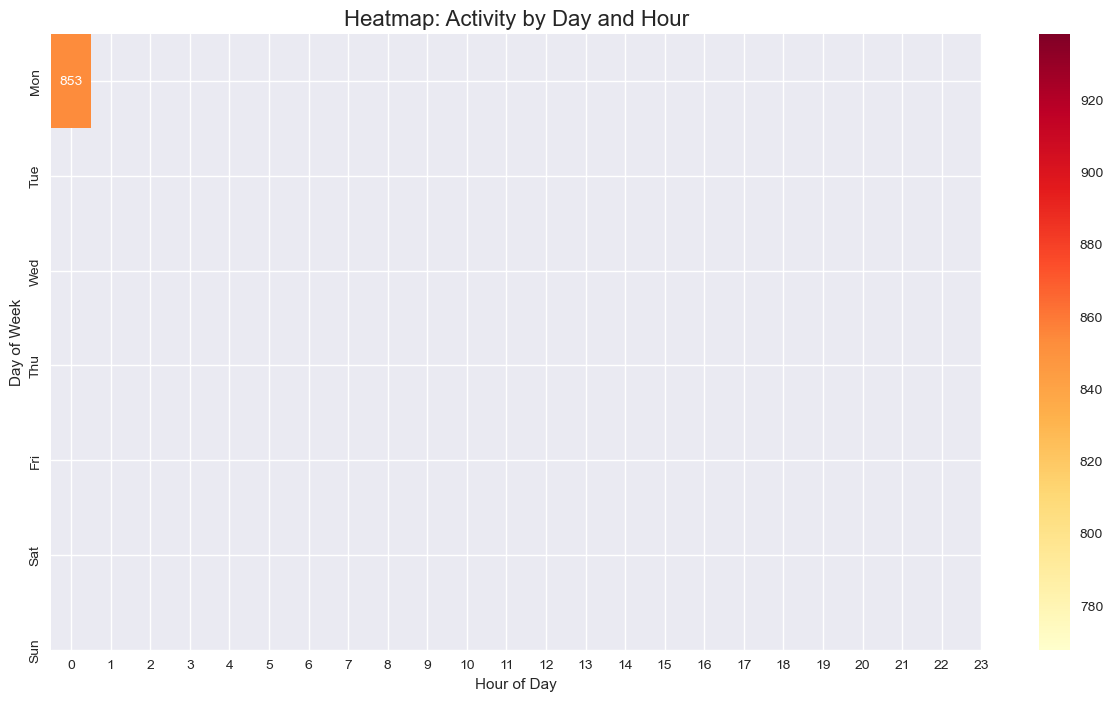

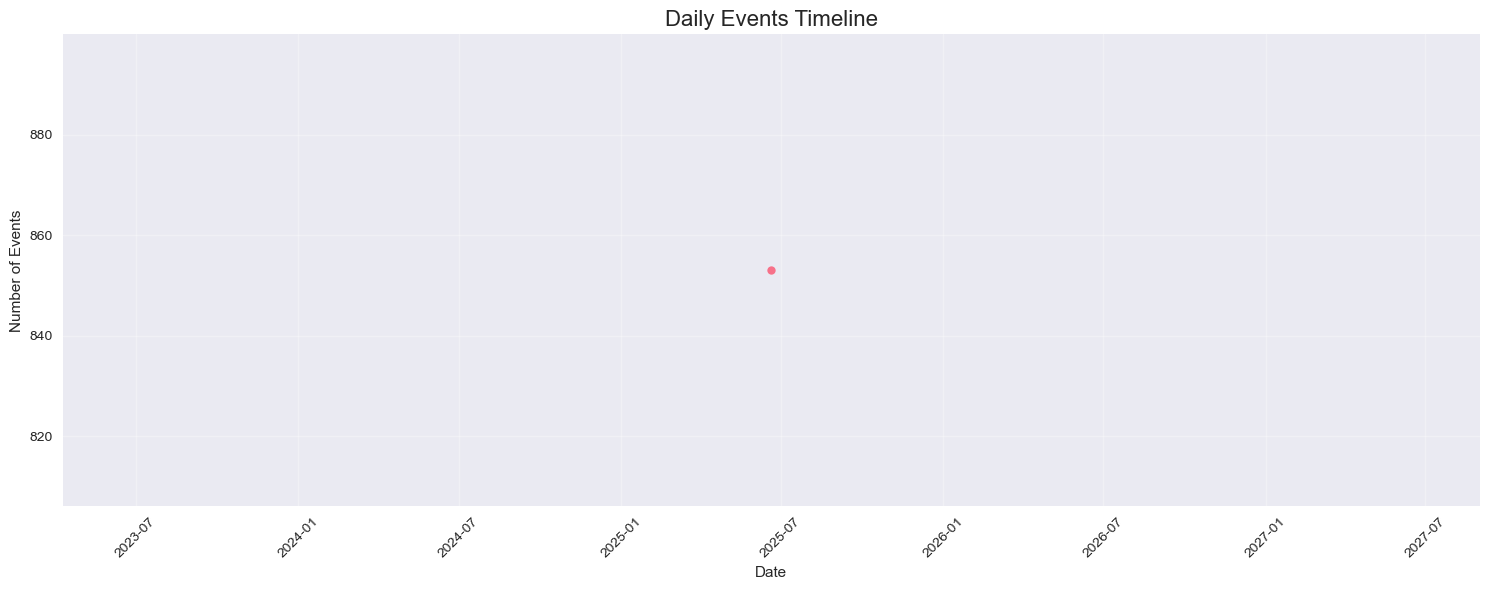

In [56]:
# Temporal Activity Heatmap and Timeline Analysis
# Metrics: Creates heatmap showing activity intensity by day of week and hour, revealing usage patterns.
# Displays daily event timeline to identify anomalous activity spikes or unusual temporal behaviors.

df['day_num'] = df['timestamp'].dt.dayofweek
activity_heatmap = df.groupby(['day_num', 'hour']).size().unstack(fill_value=0)

plt.figure(figsize=(15, 8))
sns.heatmap(activity_heatmap, 
            xticklabels=range(24), 
            yticklabels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
            annot=True, fmt='d', cmap='YlOrRd')
plt.title('Heatmap: Activity by Day and Hour', size=16)
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()

# Daily events timeline
daily_events = df.groupby(df['timestamp'].dt.date).size()
plt.figure(figsize=(15, 6))
plt.plot(daily_events.index, daily_events.values, marker='o', linewidth=2, markersize=6)
plt.title('Daily Events Timeline', size=16)
plt.xlabel('Date')
plt.ylabel('Number of Events')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [67]:
#  Log Categorization by Origin and Type
# Metrics: Classifies logs into 7 categories: API Server, System, Controllers, Authentication, User Applications, Networking, and Security/RBAC.
# Provides detailed breakdown showing event distribution, unique users, and top activity patterns per category for targeted analysis.

def categorize_logs(df):
    """
    Categorizes logs by origin and type for better analysis
    """
    log_categories = {}
    
    # Category 1: API Server Logs
    api_logs = df[
        (df['udm.metadata.product_event_type'].str.contains('api|request|response', case=False, na=False)) |
        (df['event_type'].str.contains('RESOURCE_', case=False, na=False)) |
        (df['udm.target.resource.resource_type'].notna())
    ]
    log_categories['API_SERVER'] = api_logs
    
    # Category 2: System/ServiceAccount Logs
    system_logs = df[
        df['user'].str.contains('system:', case=False, na=False)
    ]
    log_categories['SYSTEM'] = system_logs
    
    # Category 3: Kubernetes Controllers Logs
    controller_logs = df[
        df['user'].str.contains('controller|scheduler|manager', case=False, na=False)
    ]
    log_categories['CONTROLLERS'] = controller_logs
    
    # Category 4: Authentication/Authorization Logs
    auth_logs = df[
        (df['udm.metadata.product_event_type'].str.contains('auth|login|permission', case=False, na=False)) |
        (df['udm.principal.user.attribute.roles.name'].notna())
    ]
    log_categories['AUTHENTICATION'] = auth_logs
    
    # Category 5: User/Application Logs
    user_logs = df[
        (~df['user'].str.contains('system:', case=False, na=False)) &
        (~df['user'].str.contains('controller|scheduler|manager', case=False, na=False))
    ]
    log_categories['USER_APPLICATION'] = user_logs
    
    # Category 6: Networking Logs  
    network_logs = df[
        (df['udm.metadata.product_event_type'].str.contains('network|endpoint|service', case=False, na=False)) |
        (df['udm.target.resource.resource_type'].str.contains('endpoint|service', case=False, na=False))
    ]
    log_categories['NETWORKING'] = network_logs
    
    # Category 7: Security/RBAC Logs
    security_logs = df[
        (df['udm.metadata.product_event_type'].str.contains('rbac|role|permission|secret', case=False, na=False)) |
        (df['udm.target.resource.resource_type'].str.contains('role|secret|serviceaccount', case=False, na=False))
    ]
    log_categories['SECURITY_RBAC'] = security_logs
    
    return log_categories

# Execute categorization
print("CATEGORIZING LOGS BY ORIGIN AND TYPE...")
log_categories = categorize_logs(df)

print(f"\nCATEGORY SUMMARY:")
print("="*50)

total_events = len(df)
for category, logs in log_categories.items():
    percentage = (len(logs) / total_events) * 100
    print(f"{category}: {len(logs):,} events ({percentage:.1f}%)")

print(f"\nDETAILED ANALYSIS BY CATEGORY:")
print("="*50)

for category, logs in log_categories.items():
    if len(logs) > 0:
        print(f"\n{category}:")
        print(f"   - Total events: {len(logs):,}")
        print(f"   - Unique users: {logs['user'].nunique()}")
        print(f"   - Unique IPs: {logs['source_ip'].nunique()}")
        
        # Top 3 most active users in this category
        top_users = logs['user'].value_counts().head(3)
        print(f"   - Most active users:")
        for user, count in top_users.items():
            print(f"     * {user}: {count} events")
        
        # Most common event types
        top_events = logs['event_type'].value_counts().head(3)
        print(f"   - Most common event types:")
        for event_type, count in top_events.items():
            print(f"     * {event_type}: {count} events")

print(f"\nCategorization completed. Variable 'log_categories' ready for use.")


CATEGORIZING LOGS BY ORIGIN AND TYPE...

CATEGORY SUMMARY:
API_SERVER: 853 events (100.0%)
SYSTEM: 719 events (84.3%)
CONTROLLERS: 717 events (84.1%)
AUTHENTICATION: 133 events (15.6%)
USER_APPLICATION: 134 events (15.7%)
NETWORKING: 802 events (94.0%)
SECURITY_RBAC: 0 events (0.0%)

DETAILED ANALYSIS BY CATEGORY:

API_SERVER:
   - Total events: 853
   - Unique users: 8
   - Unique IPs: 9
   - Most active users:
     * system:serviceaccount:kube-system:endpointslice-controller: 368 events
     * system:serviceaccount:kube-system:endpoint-controller: 300 events
     * devops-tools-flux-oke-sa: 133 events
   - Most common event types:
     * RESOURCE_WRITTEN: 819 events
     * RESOURCE_CREATION: 34 events

SYSTEM:
   - Total events: 719
   - Unique users: 6
   - Unique IPs: 7
   - Most active users:
     * system:serviceaccount:kube-system:endpointslice-controller: 368 events
     * system:serviceaccount:kube-system:endpoint-controller: 300 events
     * system:kube-scheduler: 33 events
